### Extra, reparación de valores nulos mediante KNN

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
#cargar el dataset
df = pd.read_csv('datos/titanic.csv')#importar dataset
df.info()#vericar 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# Siguiendo tu estrategia , creamos la columna lastname para guardar el apellido de los pasajeros
df['LastName'] = df['Name'].apply(lambda x: x.split(',')[0])

In [21]:
df.info()#vericar 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  LastName     891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [7]:
# Vamos a normalizar Fare para asegurarnos que no tenga un impacto desproporcionado en la distancia 
scaler = StandardScaler()
df['Fare'] = scaler.fit_transform(df[['Fare']])

In [15]:
# estas son las columnas que quieres como predictores para tu modelo
columnas=['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked',"Age"] #la edad tiene que tenerse en cuenta al predecir, los apellidos es una variable muy random y ruidosa para introducirse

# Aplicamos OneHotEncoder para codificar nuestras variables categóricas 
encoder = OneHotEncoder(drop='first', sparse_output=False)
df_encoded = pd.DataFrame(encoder.fit_transform(df[columnas]))
df_encoded.columns = encoder.get_feature_names_out(columnas)

In [16]:
# Creamos dos dataframes basados en la presencia de Age
df_encoded['Age'] = df['Age']
df_with_age = df_encoded.dropna(subset=['Age'])
df_without_age = df_encoded[df_encoded['Age'].isna()].drop(columns='Age')

In [17]:
# Dividimos el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(df_with_age.drop(columns='Age'), df_with_age['Age'], test_size=0.2, random_state=357)

scores = [219.08405565 122.88157895 223.62027544 135.65153772 167.68399386]
scores = [136.52994217  82.51329496 155.70730219 105.13201404 123.60082807]
scores = [130.4628458   60.18006121 135.48813665 108.51132836 116.9991268 ]
scores = [117.66245815  67.15095137 127.62349945 110.55036469 131.51371228]
scores = [125.76203809  68.63970772 127.35082789 125.38223218 134.64002067]
scores = [127.75953862  76.2862182  126.66201508 128.28372641 138.96856813]


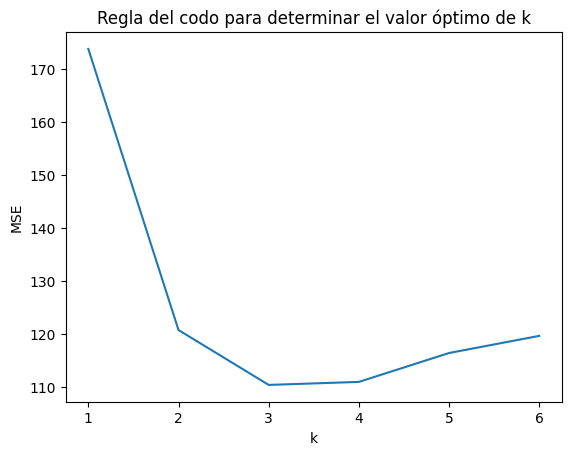

In [18]:
# Lista para almacenar los valores de MSE (Error Cuadrático Medio)
mse = []

# Rango de k para probar
k_range = range(1, 7)

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # Realizamos la validación cruzada para obtener una medida más robusta del error
    """  estamos tomando el negativo de los valores devueltos para obtener el MSE real. 
         Luego, añadimos la media de estos valores a nuestra lista de MSE para cada valor de k (mse.append(scores.mean())).
    """
    scores = -cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse.append(scores.mean())
    print(f'scores = {scores}')
    
 
# Graficamos los valores 
plt.plot(k_range, mse)
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('Regla del codo para determinar el valor óptimo de k')
plt.show()

# Graficamos 

In [19]:
# Determinar el mejor valor de k
best_k = k_range[mse.index(min(mse))]
print(f'Mejor número K: {best_k}')

Mejor número K: 3


In [20]:
# Creamos el modelo KNN con el mejor valor de k
knn = KNeighborsRegressor(n_neighbors=best_k)

# Ajustamos el modelo a los datos sin valores nulos
knn.fit(X_train, y_train)

# Imputamos los valores faltantes en la columna 'Age'
imputed_ages = knn.predict(df_without_age)
df.loc[df['Age'].isna(), 'Age'] = imputed_ages

In [22]:
df.to_csv('titanicKNN.csv', index=False)